In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [3]:
data_dir = 'Data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['men', 'women']


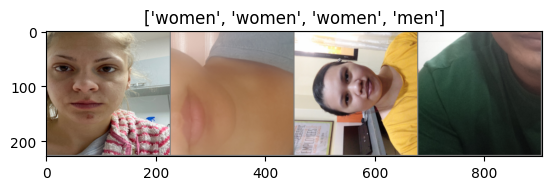

In [4]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
#### Finetuning the convnet ####
# Load a pretrained model and reset final fully connected layer.

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [11]:
# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer’s update
# e.g., you should write your code this way:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6431 Acc: 0.6500
test Loss: 0.5300 Acc: 0.7625

Epoch 1/24
----------
train Loss: 0.6009 Acc: 0.6864
test Loss: 0.4894 Acc: 0.8375

Epoch 2/24
----------
train Loss: 0.5849 Acc: 0.6818
test Loss: 0.4572 Acc: 0.8125

Epoch 3/24
----------
train Loss: 0.5854 Acc: 0.6864
test Loss: 0.4331 Acc: 0.8625

Epoch 4/24
----------
train Loss: 0.5308 Acc: 0.7318
test Loss: 0.4060 Acc: 0.8750

Epoch 5/24
----------
train Loss: 0.5394 Acc: 0.7227
test Loss: 0.3921 Acc: 0.8500

Epoch 6/24
----------
train Loss: 0.5223 Acc: 0.7409
test Loss: 0.3577 Acc: 0.8750

Epoch 7/24
----------
train Loss: 0.4791 Acc: 0.7909
test Loss: 0.3601 Acc: 0.8625

Epoch 8/24
----------
train Loss: 0.4661 Acc: 0.7864
test Loss: 0.3595 Acc: 0.8500

Epoch 9/24
----------
train Loss: 0.4939 Acc: 0.7636
test Loss: 0.3529 Acc: 0.8875

Epoch 10/24
----------
train Loss: 0.4478 Acc: 0.7955
test Loss: 0.3594 Acc: 0.8500

Epoch 11/24
----------
train Loss: 0.4701 Acc: 0.8000
test Loss: 0.3496 Acc

In [12]:
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

In [13]:
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7967 Acc: 0.5727
test Loss: 0.5327 Acc: 0.7500

Epoch 1/24
----------
train Loss: 0.6075 Acc: 0.6955
test Loss: 0.4456 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.6324 Acc: 0.6273
test Loss: 0.6629 Acc: 0.7000

Epoch 3/24
----------
train Loss: 0.7221 Acc: 0.6545
test Loss: 0.6354 Acc: 0.7500

Epoch 4/24
----------
train Loss: 0.7926 Acc: 0.6455
test Loss: 1.1804 Acc: 0.6125

Epoch 5/24
----------
train Loss: 0.7311 Acc: 0.6818
test Loss: 0.3679 Acc: 0.8250

Epoch 6/24
----------
train Loss: 0.6144 Acc: 0.7045
test Loss: 0.4437 Acc: 0.7875

Epoch 7/24
----------
train Loss: 0.5289 Acc: 0.7136
test Loss: 0.3716 Acc: 0.8750

Epoch 8/24
----------
train Loss: 0.4250 Acc: 0.8136
test Loss: 0.3628 Acc: 0.8500

Epoch 9/24
----------
train Loss: 0.6422 Acc: 0.7091
test Loss: 0.3940 Acc: 0.8500

Epoch 10/24
----------
train Loss: 0.4624 Acc: 0.7591
test Loss: 0.3716 Acc: 0.8375

Epoch 11/24
----------
train Loss: 0.5124 Acc: 0.7364
test Loss: 0.3626 Acc